In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os 
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from extra_keras_datasets import emnist
from skimage import transform
from tensorflow.keras.models import load_model
import datetime 

import warnings
warnings.filterwarnings('ignore')

c:\Users\giann\anaconda3\envs\tf_best\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def unflatten_images(images:np.array, width:int, height:int):
    """
    This method will reshape each flatten image to a square like image.

    Args:
        images (np.array): array of flatten images

    Returns:
        (np.array,np.array)
    """

    unflatten_images = images.reshape((len(images), width, height, 1))
    transposed_unflatten_images= np.transpose(unflatten_images, (0, 2, 1, 3))

    return transposed_unflatten_images

In [3]:
def get_emnist_data(path:str = "no_path"):
    """
    Method to load data wheter from a path to a csv file or from the extra_kagle_datasets.

    Args:
        path (str, optional): Path if we want to load data from csv. Defaults to "no_path".

    Returns:
        (np.array,np.array,np.array,np.array): train_images, encoded_train_labels, test_images, encoded_test_labels
    """

    if path == "no_path":
        (train_images, train_labels), (test_images, test_labels) =  emnist.load_data()


        train_images=np.reshape(train_images, [len(train_images),28,28, 1]) 
        test_images=np.reshape(test_images, [len(test_images),28,28, 1] ) 

    else:
        train_path = os.path.join(path,"emnist-balanced-train.csv")
        test_path = os.path.join(path,"emnist-balanced-test.csv" )

        train_data = np.array(pd.read_csv(train_path))
        test_data = np.array(pd.read_csv(test_path))

        train_images = unflatten_images(train_data[:,1:],
                                                      28,
                                                      28)
        test_images = unflatten_images(test_data[:, 1:],
                                                    28,
                                                    28)
        train_labels = train_data[:, :1]
        test_labels = test_data[:, :1]
    
    encoded_train_labels = tf.keras.utils.to_categorical(train_labels, 47)
    encoded_test_labels = tf.keras.utils.to_categorical(test_labels, 47)

    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255
    
    print(f"Train data is of shape: {train_images.shape}")
    print(f"Train labels is of shape: {train_labels.shape}")
    print(f"Test data is of shape: {test_images.shape}")
    print(f"Test labels is of shape: {test_labels.shape}")

    return train_images, encoded_train_labels, test_images, encoded_test_labels

##### Loading train data from csv file of the emnist balanced dataset

In [43]:
train_images, train_labels, test_images, test_labels = get_emnist_data('Z:/Master I/PML - Practical Machine Learning/Jiani/data')

Train data is of shape: (112799, 28, 28, 1)
Train labels is of shape: (112799, 1)
Test data is of shape: (18799, 28, 28, 1)
Test labels is of shape: (18799, 1)


##### Loading train data from  keras extended datasets

In [7]:
train_images, train_labels, test_images, test_labels = get_emnist_data()

INFO:root:Loading dataset = emnist


Train data is of shape: (112800, 28, 28, 1)
Train labels is of shape: (112800,)
Test data is of shape: (18800, 28, 28, 1)
Test labels is of shape: (18800,)


In [8]:
def plot_images(images, nr_of_images: int):
    """
    Method used to plot some images after loading in order to check if the images we're loaded correctly.

    Args:
        images (np.array): Loaded images
        nr_of_images (int): Number of images to show (it should be a squared number)
    """
    nr_of_images_per_axe = int(np.sqrt(nr_of_images))
    _, axs = plt.subplots(nr_of_images_per_axe, nr_of_images_per_axe, figsize=(5, 5))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img)
    plt.show()

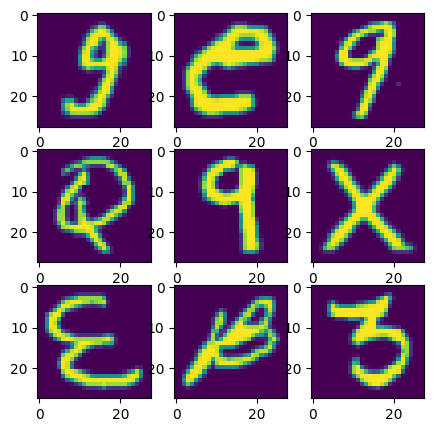

In [9]:
plot_images(test_images,9)

In [4]:
def resize_batch(imgs,width,height):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], width, height, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (width, height))
    return resized_imgs

In [5]:
class DataGenerator(Sequence):
    """
    Generator used because we want the model to load a
    batch at a time on the GPU in order to avoid memory problems.
    """
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 resize_info,
                 add_dims:bool = False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.width, self.height = resize_info
        self.add_dims = add_dims

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        resized_batch_x = resize_batch(batch_x,
                                       self.width,
                                       self.height)

        if self.add_dims:
            resized_batch_x = np.repeat(resized_batch_x,3,-1)

        return resized_batch_x, batch_y

In [12]:
train_gen = DataGenerator(train_images,
                          train_labels,
                          32,
                          (32,32) ,
                          True)
test_gen = DataGenerator(test_images,
                         test_labels,
                         32,
                         (32,32),
                          True)

In [32]:
def get_model(model_name:str,
              used_opt,
              used_loss_fn,
              used_metrics,
              num_labels,
              used_input_shape = (32, 32, 3),
              trainable = False,
              layers_to_train = None):

    if model_name.lower() == "mobilenet":
        if layers_to_train != None:
            pretrained_model = tf.keras.applications.MobileNetV2(alpha=0.75,
                                                                input_shape=list(used_input_shape),
                                                                include_top=False,
                                                                weights='imagenet')
            pretrained_model.trainable = trainable 

            model = tf.keras.Sequential([
                pretrained_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(1000,activation='relu'),
                tf.keras.layers.Dense(num_labels, activation='softmax')
            ])
        else:
            pretrained_model = tf.keras.applications.MobileNetV2(alpha=0.75,
                                                                input_shape=list(used_input_shape),
                                                                include_top=False,
                                                                weights='imagenet')
            # Fine-tune from this layer onwards
            fine_tune_at = layers_to_train

            for layer in pretrained_model.layers[fine_tune_at:]:
                layer.trainable =  True

            model = tf.keras.Sequential([
                pretrained_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(1000,activation='relu'),
                tf.keras.layers.Dense(num_labels, activation='softmax')
            ])
            #create mobilenet with more trainable layers 


    elif model_name.lower() == "cnn":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=used_input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(num_labels, activation='softmax')
        ])

    model.compile(optimizer=used_opt,
                  loss=used_loss_fn,
                  metrics=used_metrics)

    return model

In [41]:
def save_model_as_tflite_file(trained_model, out_path:str, save_name = 'model'):
    """
    Method that can be used to save a tensorflow model to a tflite file.

    Args:
        trained_model (_type_): Model to be saved.
        out_path (str): Path to where to save the tflite file.
        save_name (str, optional): Name of the saved model. Defaults to 'model'.
    """

    # convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
    tflite_model = converter.convert()

    # save the model 
    with open(os.path.join(out_path , save_name + '.tflite'), 'wb') as f:
        f.write(tflite_model)

###  1. FINE TUNE MOBILENET

In [46]:
# load data
train_images, train_labels, test_images, test_labels = get_emnist_data()

# create data generators
train_gen = DataGenerator(train_images,
                          train_labels,
                          32,
                          (32,32),
                          True)
test_gen = DataGenerator(test_images,
                         test_labels,
                         32,
                         (32,32),
                          True)

# create model
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics=['accuracy',]

model = get_model("mobilenet",
                  optimizer,
                  loss_fn,
                  metrics,
                  47,
                  trainable = True,
                  layers_to_train = 70)
model.summary()

# schedular to decay the learning rate
def scheduler_100_epochs(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * tf.math.exp(-0.1)
    elif epoch <= 50:
        return lr * tf.math.exp(-0.01)
    elif epoch <= 90:
        return lr * tf.math.exp(-0.01)
    else :
        return lr

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_100_epochs)

# callback for saving the best model
model_checkpoint_callback = ModelCheckpoint(filepath= f'Jiani/checkpoints/mobilenet/best_model.h5',
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose = True)

# callback to save tensorboard logs for later visualization
log_dir = "Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/mobilenet/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# train 
history = model.fit(train_gen,
                    epochs=100,
                    validation_data=test_gen,
                    callbacks=[lr_schedule_callback, model_checkpoint_callback, tensorboard_callback])

INFO:root:Loading dataset = emnist


Train data is of shape: (112800, 28, 28, 1)
Train labels is of shape: (112800,)
Test data is of shape: (18800, 28, 28, 1)
Test labels is of shape: (18800,)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.75_224 (Funct  (None, 1, 1, 1280)       1382064   
 ional)                                                          
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 1000)              1281000   
                                                                 
 dense_18 (Dense)            (None, 47)                47047     
                                                                 
Total params: 2,710,111
Trainable params: 2,683,471
Non-trainable params: 26,640
_________________________________________________________________
Epoch 1/100
  91/3525 [................

KeyboardInterrupt: 

In [29]:
layers = [1,2,3,4,5]
fine_tune_at = 4
for layer in layers[fine_tune_at:]:
    print(layer)

5


##### Load best fine tuned mobilenet model and save in the tflite format

In [48]:
from tensorflow.keras.models import load_model

model = load_model(f'Jiani/checkpoints/mobilenet/best_model.h5')
model.summary()

save_name = "fine_tuned_mobilenet_best_model"
save_model_as_tflite_file(model,f'Jiani/checkpoints/mobilenet/',save_name)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.75_224 (Funct  (None, 1, 1, 1280)       1382064   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1000)              1281000   
                                                                 
 dense_16 (Dense)            (None, 47)                47047     
                                                                 
Total params: 2,710,111
Trainable params: 1,328,047
Non-trainable params: 1,382,064
_________________________________________________________________


INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmp75vm0qg4\assets


INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmp75vm0qg4\assets


### 2. MY CNN MODEL 

##### Method to train using cross validation

In [51]:
def train_cross_fold_save_best_model(model,
                                     train_data,
                                     train_labels,
                                     test_data,
                                     test_labels,
                                     save_best_weights_path,
                                     epochs):

    acc_per_fold, loss_per_fold = [], []

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=5, shuffle=True)
    fold_n = 1
    for train, test in kfold.split(train_data, train_labels):
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_n} ...')

        model_checkpoint_callback = ModelCheckpoint(
            filepath= f'Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/model_my_cnn/{fold_n}/best_model.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose = True)

        def scheduler_50_epochs(epoch, lr):
            if epoch < 20:
                return lr
            elif epoch < 30:
                return lr * tf.math.exp(-0.1)
            elif epoch <= 50:
                return lr * tf.math.exp(-0.01)
            else :
                return lr

        lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_50_epochs)

        # callback to save tensorboard logs for later visualization
        log_dir = "Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/model_my_cnn/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        # Fit data to model
        history = model.fit(train_images[train], train_labels[train],
                            initial_epoch=0,
                            batch_size=32,
                            epochs=epochs,
                            validation_data=[train_images[test], train_labels[test]],
                            callbacks=[lr_schedule_callback, model_checkpoint_callback,tensorboard_callback])

        # Generate generalization metrics
        # model.load_weights(f'Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/model_my_cnn/{fold_n}/best_checkpoint.ckpt')

        model = load_model(f"Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/model_my_cnn/{fold_n}/best_model.h5")
        scores = model.evaluate(train_images[test], train_labels[test], verbose=0)
        print(f'Score for fold {fold_n}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_n += 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        # test_loss, test_metrics = model.evaluate(test_data, test_labels, verbose=1) 

##### Train 

In [52]:
# load data
train_images, train_labels, test_images, test_labels = get_emnist_data('Z:/Master I/PML - Practical Machine Learning/Jiani/data')

# create model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics=['accuracy',]

model = get_model("cnn",
                  optimizer,
                  loss_fn,
                  metrics,
                  47,
                  used_input_shape=(28, 28, 1),
                  trainable = False)
model.summary()

# train 
train_cross_fold_save_best_model(model,
                                 train_images,
                                 train_labels,
                                 test_images,
                                 test_labels,
                                 "",
                                 50)

Train data is of shape: (112799, 28, 28, 1)
Train labels is of shape: (112799, 1)
Test data is of shape: (18799, 28, 28, 1)
Test labels is of shape: (18799, 1)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_7 (B

KeyboardInterrupt: 

##### Load best CNN model and save in the tflite format

In [43]:
from tensorflow.keras.models import load_model

fold_n = 1

model = load_model(f"Jiani/checkpoints/model_my_cnn/{fold_n}/best_model.h5")
model.summary()

save_name = "my_cnn_best_model"
save_model_as_tflite_file(model,f"Jiani/checkpoints/model_my_cnn/{fold_n}/",save_name)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 11, 11, 128)      512       
 chNormalization)                                                
                                                      

INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmpmg8h53pr\assets


INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmpmg8h53pr\assets


## 3. NL-CNN model

#### Method used to create the model

In [17]:
# code from : https://github.com/radu-dogaru/NL-CNN-a-compact-fast-trainable-convolutional-neural-net/blob/main/nl_cnn_demos.ipynb

# NL_CNN MODEL 
# Returns a precompiled model with a specific optimizer included 
#==============================================================================================
from tensorflow.keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers  import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling 
from tensorflow.keras.optimizers import  SGD, Adadelta, Adam, Nadam


def create_nl_cnn_model(input_shape, num_classes, k=1.5,separ=0, flat=0, width=80, nl=(3,2), add_layer=0):
  # Arguments: k - multiplication coefficient 
  # Structure parameteres 
  kfil=k
  filtre1=width ; filtre2=int(kfil*filtre1) ; filtre3=(kfil*filtre2)  # filters (kernels) per each layer - efic. pe primul 
  nr_conv=3 # 0, 1, 2 sau 3  (number of convolution layers)
  csize1=3; csize2=3 ; csize3=3      # convolution kernel size (square kernel) 
  psize1=4; psize2=4 ; psize3=4      # pooling size (square)
  str1=2; str2=2; str3=2             # stride pooling (downsampling rate) 
  pad='same'; # padding style ('valid' is also an alternative)
  nonlinlayers1=nl[0]  # total of layers (with RELU nonlin) in the first maxpool layer  # De parametrizat asta 
  nonlinlayers2=nl[1]  # 

  nonlin_type='relu' # may be other as well 'tanh' 'elu' 'softsign'
  bndrop=1 # include BatchNorm inainte de MaxPool si drop(0.3) dupa .. 
  cvdrop=1 # droput 
  drop_cv=0.5
  
  model = Sequential()
  # convolution layer1  ==========================================================================
  # Initially first layer was always a Conv2D one
  if separ==1:
    model.add( SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )
  elif separ==0: 
    model.add( Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )

  # next are the additional layers 
  for nl in range(nonlinlayers1-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
      model.add(SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1) ) ) # Activ NL-CNN-2
    elif separ==0:
      model.add(Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1)) ) # Activ NL-CNN-2
  #  MaxPool in the end of the module 
  if bndrop==1:
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize1, psize1),strides=(str1,str1),padding=pad))
  if cvdrop==1:
    model.add(Dropout(drop_cv))
  
  # NL LAYER 2 =======================================================================================================
 
  if separ==1:
    model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  elif separ==0:
    model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  # aici se adauga un neliniar 
    
  #=========== unul extra NL=2 pe strat 2 =====================
  for nl in range(nonlinlayers2-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
        model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
    elif separ==0:
        model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
        
  # OUTPUT OF LAYER 2 (MAX-POOL)
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize2, psize2),strides=(str2,str2),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #-------------------------------------------------------------------------------------------
  # LAYER 3 
      
  if separ==1:
      model.add(SeparableConv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
  elif separ==0:
      model.add(Conv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
  # OUTPUT OF LAYER 3 
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #------------------- 
  # 
  # LAYER 4  (only if requested - for large images ?? )
  if add_layer==1:    
    if separ==1:
      model.add(SeparableConv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
    elif separ==0:
      model.add(Conv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
    # OUTPUT OF LAYER 4
    if bndrop==1:
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
    if cvdrop==1:
      model.add(Dropout(drop_cv))
  #========================================================================================
  # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice ) 
  if flat==1:
      model.add(Flatten())  # 
  elif flat==0:
      model.add(GlobalAveragePooling2D()) # Global average 
   
  model.add(Dense(num_classes, activation='softmax'))
  # END OF MODEL DESCRIPTION 
  # ------------------ COMPILE THE MODEL
  myopt = Adam()
  #myopt = Nadam()
  if separ==1:
    myopt = RMSprop(lr=0.01) 
    #myopt = Adam(lr=0.05)

  # --------------------------   LOSS function  ------------------------------------
  my_loss='categorical_crossentropy'
  model.compile(loss=my_loss, 
              optimizer=myopt,   
              metrics=['accuracy'])

  return model

#### Train

In [ ]:
# load data
train_images, train_labels, test_images, test_labels = get_emnist_data()

# create data generators
train_gen = DataGenerator(train_images,
                          train_labels,
                          32,
                          (32,32),
                          True)
test_gen = DataGenerator(test_images,
                         test_labels,
                         32,
                         (32,32),
                          True)

# create model
model = create_nl_cnn_model((32, 32, 3), 47, k=2, separ=0, flat=1, width=40, nl=(2,2), add_layer=0)
model.summary()

# create necessary checkpoints
model_checkpoint_callback = ModelCheckpoint(filepath= f'Jiani/checkpoints/nl_cnn/best_model.h5',
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose = True)

# callback to save tensorboard logs for later visualization
log_dir = "Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints/nl_cnn/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# train
history = model.fit(train_gen,
                    epochs=100,
                    validation_data=test_gen,
                    callbacks=[model_checkpoint_callback, tensorboard_callback])

##### Load best NL-CNN model and save in the tflite format

In [33]:
from tensorflow.keras.models import load_model

model = load_model("Jiani/checkpoints/nl_cnn/best_model.h5")
model.summary()

save_name = "nl_cnn_best_model"
save_model_as_tflite_file(model,"Jiani/checkpoints/nl_cnn/",save_name)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 40)        1120      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 40)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 40)        14440     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 40)       160       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 40)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 40)       

INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmps55b9f_0\assets


INFO:tensorflow:Assets written to: C:\Users\test\AppData\Local\Temp\tmps55b9f_0\assets


### CONCLUSION

In [7]:
model_names = ["cnn","mobilenet_nottrainable", "mobilenet_trainable", "nl_cnn"]

losses = []
acc = []
model_name = []

for index, model in enumerate(model_names):
    if model=="cnn":
        train_images, train_labels, test_images, test_labels = get_emnist_data('Z:/Master I/PML - Practical Machine Learning/Jiani/data/emnist-balanced-train.csv')
        # folds = range(1,6)
        folds = [1]
        for fold in folds:
            model = load_model(os.path.join("Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints_jiani",model_names[index],f"{fold}/best_model.h5"))
            loss, ac = model.evaluate(test_images, test_labels)
            losses.append(loss)
            acc.append(ac)
            model_name.append("cnn"+f"_fold_{fold}")
    else:
        train_images, train_labels, test_images, test_labels = get_emnist_data()

        test_gen = DataGenerator(test_images,
                                 test_labels,
                                 32,
                                 (32,32),
                                  True)
        
        model = load_model(os.path.join("Z:/Master I/PML - Practical Machine Learning/Jiani/checkpoints_jiani",model_names[index],"best_model.h5"))
        loss, ac = model.evaluate(test_gen)
        losses.append(loss)
        acc.append(ac)
        model_name.append(model_names[index])

Train data is of shape: (100000, 28, 28, 1)
Train labels is of shape: (100000, 1)
Test data is of shape: (12799, 28, 28, 1)
Test labels is of shape: (12799, 1)
400/400 [==============================] - 4s 8ms/step - loss: 0.5183 - accuracy: 0.8798


INFO:root:Loading dataset = emnist


Train data is of shape: (112800, 28, 28, 1)
Train labels is of shape: (112800,)
Test data is of shape: (18800, 28, 28, 1)
Test labels is of shape: (18800,)
588/588 [==============================] - 13s 21ms/step - loss: 1.4008 - accuracy: 0.6063


INFO:root:Loading dataset = emnist


Train data is of shape: (112800, 28, 28, 1)
Train labels is of shape: (112800,)
Test data is of shape: (18800, 28, 28, 1)
Test labels is of shape: (18800,)
588/588 [==============================] - 13s 20ms/step - loss: 0.4131 - accuracy: 0.8881


INFO:root:Loading dataset = emnist


Train data is of shape: (112800, 28, 28, 1)
Train labels is of shape: (112800,)
Test data is of shape: (18800, 28, 28, 1)
Test labels is of shape: (18800,)
588/588 [==============================] - 6s 9ms/step - loss: 0.2908 - accuracy: 0.9021


In [19]:
column_names = ['model_name', 'loss', 'accuracy']

# Create a dictionary from the lists
metrics = {
    'model_name': model_name,
    'loss': losses,
    'accuracy': acc
}

# Create a Pandas DataFrame
df = pd.DataFrame(metrics,
                  columns=column_names)

# Display the DataFrame
print(df)

               model_name      loss  accuracy
0              cnn_fold_1  0.518292  0.879834
1  mobilenet_nottrainable  1.400829  0.606330
2     mobilenet_trainable  0.413101  0.888085
3                  nl_cnn  0.290777  0.902074
